## Imports

In [1]:
# Python imports
import os
import sys
import json
from pathlib import Path
import gc
import inspect
from copy import deepcopy
from copy import copy
from datetime import datetime

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm.notebook import tqdm

In [2]:
# Transformer imports
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import torch

In [3]:
# Local imports
sys.path.insert(0, '..')
from visualization.visualization_utils import *

sys.path.insert(0, '../DSL')
from dsl import *
from constants import *
from solver_class import Solver
import solvers
import verifiers
import verifiers_reformatted

## Hyperparameters

In [28]:
NUM_TRAIN_EPOCHS = 1 # We use every re-arc pair in our training
NUM_RE_ARC_EXAMPLES_PER_TASK_PER_EPOCH = 20 # No longer used
MAX_SEQ_LENGTH = 1536 # 2048 is took big, OOM. Also got OOM with 1536 but only intermittently.

## Load data

In [5]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'
re_arc_path = data_path / 're-arc_tasks'

In [6]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)

train_task_labels = sorted(train_tasks.keys())

#with open(eval_path, 'r') as f:
#    eval_tasks = json.load(f)
#with open(eval_sols_path, 'r') as f:
#    eval_sols = json.load(f)

#eval_task_labels = sorted(eval_tasks.keys())

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


## Load model and tokenizer

In [8]:
codegen_tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                                 #padding_side='left', # For padding batches of input in decoder-only context
                                                 clean_up_tokenization_spaces = True,
                                                 )
codegen = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono")
codegen = codegen.to(DEVICE)

In [9]:
EOS_TOKEN = codegen_tokenizer.eos_token
BOS_TOKEN = codegen_tokenizer.bos_token
codegen_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#codegen_tokenizer.pad_token = codegen_tokenizer.eos_token

1

## Create training data

In [10]:
# Load Hodel's solvers and verifiers.
# Verifiers are reformatted to look the same as the solvers.
solver_programs = {label: Solver(inspect.getsource(getattr(solvers, f"solve_{label}"))) for label in train_task_labels}
verifier_programs = {label: Solver(inspect.getsource(getattr(verifiers_reformatted, f"solve_{label}"))) for label in train_task_labels}

In [11]:
# Set names of solvers to 'solve', i.e. remove labels
for _, solver in solver_programs.items():
    solver.rename('solve')
for _, solver in verifier_programs.items():
    solver.rename('solve')

In [13]:
# TODO: Refactor to utilities file

def grid_to_string(grid):
    """
    Simply converts grid to string and removes whitespace.
    A 30-by-30 grid will use ~1800 tokens.
    """
    return str(grid).replace(" ", "")

def grid_to_string_compact(grid):
    """
    Rows as strings of characters separated by linebreaks.
    Uses approximately 4-times fewer tokens than grid_to_string.
    """
    return "\n".join(["".join([str(entry) for entry in row]) for row in grid])

In [14]:
def get_n_random_re_arc_pairs(label: str, n: int) -> list[dict]:
    with open(re_arc_path / f"{label}.json", "r") as f:
        re_arc_examples = json.load(f)
    return random.sample(re_arc_examples, n)

In [15]:
def create_training_example(solver: Solver, in_grid, out_grid, compact = True) -> str:
    """
    Adds docstring to a solver showing input/output grids.
    """
    in_grid_str = grid_to_string_compact(in_grid) if compact else grid_to_string(in_grid)
    out_grid_str = grid_to_string_compact(out_grid) if compact else grid_to_string(out_grid)

    docstring = f"""
    INPUT:
    {in_grid_str}
    OUTPUT:
    {out_grid_str}
    """
    solver.update_docstring(docstring)
    
    solver_text = str(solver).strip()
    return solver_text + EOS_TOKEN

In [16]:
# Show an example
l = random.choice(train_task_labels)
print(l)
print("")
in_grid = train_tasks[l]['train'][0]['input']
out_grid = train_tasks[l]['train'][0]['output']
solver = solver_programs[l]
print(create_training_example(solver, in_grid, out_grid))

ce602527

def solve(I):
    """
    INPUT:
    11111111111111111
    11111111111111111
    11111111111331331
    11122222111311131
    11121212111333331
    11111112111113111
    11121212111333331
    11122222111111111
    11111111111111111
    11188888888881111
    11188888888881111
    11188118811881111
    11188118811881111
    11111111111881111
    11111111111881111
    11188118811881111
    11188118811881111
    OUTPUT:
    22222
    21212
    11112
    21212
    22222
    """
    x1 = vmirror(I)
    x2 = fgpartition(x1)
    x3 = order(x2, size)
    x4 = last(x3)
    x5 = remove(x4, x3)
    x6 = compose(toindices, normalize)
    x7 = rbind(upscale, TWO)
    x8 = chain(toindices, x7, normalize)
    x9 = x6(x4)
    x10 = rbind(intersection, x9)
    x11 = chain(size, x10, x8)
    x12 = argmax(x5, x11)
    x13 = subgrid(x12, x1)
    O = vmirror(x13)
    return O<|endoftext|>


In [17]:
# Check worst case for number of tokens needed to encode an example
max_tokens_needed = 0
for label in tqdm(train_task_labels):
    solver = solver_programs[label]
    verifier = verifier_programs[label]
    N = len(train_tasks[label]['train'])
    M = len(train_tasks[label]['test'])
    for i in range(N):
        in_grid = train_tasks[label]['train'][i]['input']
        out_grid = train_tasks[label]['train'][i]['output']
        solver_ex = create_training_example(solver, in_grid, out_grid)
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))
    for i in range(M):
        in_grid = train_tasks[label]['test'][i]['input']
        out_grid = train_sols[label][i]
        solver_ex = create_training_example(solver, in_grid, out_grid)
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))
    with open(re_arc_path / f"{label}.json") as f:
        re_arc_pairs = json.load(f)
        for pair in re_arc_pairs:
            in_grid = pair['input']
            out_grid = pair['output']
            solver_ex = create_training_example(solver, in_grid, out_grid)
            verifier_ex = create_training_example(verifier, in_grid, out_grid)
            max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
            max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))

  0%|          | 0/400 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2059 > 2048). Running this sequence through the model will result in indexing errors


In [18]:
print(f"Maximum number of tokens possibly needed for training examples: {max_tokens_needed}")

Maximum number of tokens possibly needed for training examples: 2786


In [31]:
training_examples = []
token_counts = []

# TODO refactor this

for label in tqdm(train_task_labels):
    N = len(train_tasks[label]['train'])
    M = len(train_tasks[label]['test'])
    
    solver = solver_programs[label]
    verifier = verifier_programs[label]

    # Create solver examples from ordinary arc tasks
    for i in range(N):
        in_grid = train_tasks[label]['train'][i]['input']
        out_grid = train_tasks[label]['train'][i]['output']
        solver_ex = create_training_example(solver, in_grid, out_grid)
        token_count = len(codegen_tokenizer.tokenize(solver_ex))
        if token_count > MAX_SEQ_LENGTH:
            first_half = solver_ex[:len(solver_ex)//2]
            second_half = solver_ex[len(solver_ex)//2:]
            training_examples.append(first_half)
            training_examples.append(second_half)
        else:
            training_examples.append(solver_ex)
            token_counts.append(token_count)
    for i in range(M):
        in_grid = train_tasks[label]['test'][i]['input']
        out_grid = train_sols[label][i]
        solver_ex = create_training_example(solver, in_grid, out_grid)
        token_count = len(codegen_tokenizer.tokenize(solver_ex))
        if token_count > MAX_SEQ_LENGTH:
            first_half = solver_ex[:len(solver_ex)//2]
            second_half = solver_ex[len(solver_ex)//2:]
            training_examples.append(first_half)
            training_examples.append(second_half)
            token_counts.append(len(codegen_tokenizer.tokenize(first_half)))
            token_counts.append(len(codegen_tokenizer.tokenize(second_half)))
        else:
            training_examples.append(solver_ex)
            token_counts.append(token_count)

    # Create verifier examples from re-arc tasks
    with open(re_arc_path / f"{label}.json", "r") as f:
        re_arc_pairs = json.load(f)
    for pair in re_arc_pairs:
        in_grid = pair['input']
        out_grid = pair['output']
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        token_count = len(codegen_tokenizer.tokenize(verifier_ex))
        if token_count > MAX_SEQ_LENGTH:
            first_half = verifier_ex[:len(verifier_ex)//2]
            second_half = verifier_ex[len(verifier_ex)//2:]
            training_examples.append(first_half)
            training_examples.append(second_half)
            token_counts.append(len(codegen_tokenizer.tokenize(first_half)))
            token_counts.append(len(codegen_tokenizer.tokenize(second_half)))
        else:
            training_examples.append(verifier_ex)
            token_counts.append(token_count)

  0%|          | 0/400 [00:00<?, ?it/s]

In [32]:
print(f"We have {len(training_examples)} training examples, an average of {len(training_examples) / 400} per task.")

We have 407194 training examples, an average of 1017.985 per task.


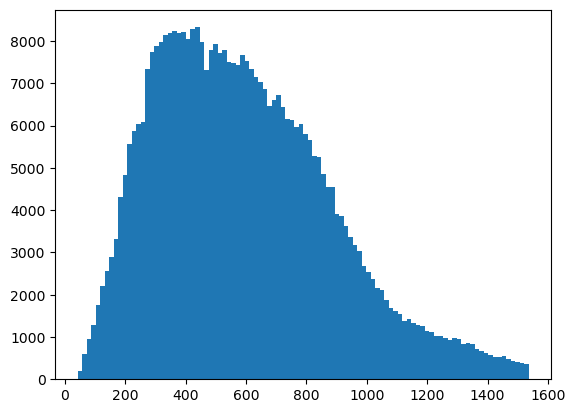

Maximum number of tokens actually needed for training examples: 1536
A total of 0 examples exceed 2048 tokens
A total of 0 examples exceed 1536 tokens


In [33]:
plt.hist(token_counts, bins = 100)
plt.show()
print(f"Maximum number of tokens actually needed for training examples: {max(token_counts)}")
print(f"A total of {sum([count > 2048 for count in token_counts])} examples exceed 2048 tokens")
print(f"A total of {sum([count > 1536 for count in token_counts])} examples exceed 1536 tokens")

In [34]:
dataset = Dataset.from_dict({'text': training_examples})

## Train and save

In [35]:
trainer = SFTTrainer(
    model = codegen,
    tokenizer = codegen_tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        dataset_text_field = "text",
        max_seq_length = MAX_SEQ_LENGTH, 
        num_train_epochs = NUM_TRAIN_EPOCHS,
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False,
        logging_steps = 2000,
        save_steps = 4000,
        optim = "adamw_torch",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/407194 [00:00<?, ? examples/s]

In [36]:
trainer.train()

Step,Training Loss
2000,0.575700
4000,0.470900
6000,0.443500
8000,0.419400
10000,0.405300
12000,0.392300
14000,0.377100
16000,0.380000
18000,0.366300
20000,0.359900


TrainOutput(global_step=50899, training_loss=0.3582233393055748, metrics={'train_runtime': 30142.0462, 'train_samples_per_second': 13.509, 'train_steps_per_second': 1.689, 'total_flos': 4.433056696892129e+17, 'train_loss': 0.3582233393055748, 'epoch': 0.9999950883362722})